# Imports

In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
3
NVIDIA GeForce RTX 3090


In [2]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler, create_dataloaders, discard_random_labels, remove_duplicates_preserve_order, order_labels_and_array_with_target
from orbit_generation.processing import reorder_orbits, interpolate_equal_times
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits, export_dynamic_orbits_html
from orbit_generation.stats import plot_histograms_comparison
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model_factory import get_model
from orbit_generation.architectures import VAELossHistory
from orbit_generation.propagation import jacobi_constant, calculate_errors_per_orbit
from orbit_generation.experiment import setup_new_experiment, add_experiment_metrics, plot_corr_matrix, get_experiment_data
from orbit_generation.evaluation import evaluate_clustering_multiple_labels, find_nearest_orbits_batch, calculate_pairwise_orbit_distances, calculate_distances_batch, find_nearest_points_batch, calculate_pairwise_distances, find_nearest_orbits
from orbit_generation.latent_space import sample_random_distributions, plot_2d_latent_space, plot_combined_2d_latent_space, reduce_dimensions_latent_space, compute_centroids, grid_sample
from orbit_generation.convergence import process_diferential_correction_orbits

In [3]:
import numpy as np
import os
from pytorch_lightning import Trainer

In [4]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
import logging

logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

# Parameters

In [6]:
want_to_train = True   # Set this parameter to False if you want to load the model from the folder
want_to_generate = True    # Set this parameter to False if you want to load the generation from the folder
calculate_error_metrics = True   # Set this parameter to False if you don't want to calculate any metric
want_to_get_cluster_metrics = True    # Set this parameter to False if you don't want to calculate clustering metrics
want_to_perform_convergence = True   # Set this parameter to False if you don't want to perform convergence
want_to_discover = True            # Set this parameter to False if you don't want to study the discovery

assert want_to_train==want_to_discover

In [7]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

The following cell will be overriden by the '03_02_experiment_parameterization' script

In [ ]:
# parameters
data_used = "default_data"
families_to_discard = 0
seq_len = 100
feature_dim = 7
epochs = 5
val_split = 0.05
batch_size = 32
lr = 0.001
model_name = "inception_time_wp_vae"
latent_dim = 2
model_kwargs = {'beta': 1, 'n_filters': 32, 'kernel_sizes': [3, 5, 13], 'bottleneck_channels': 32}
max_iter_convergence = 25
input_seq_len_convergence = 1
samples_to_generate = 100
distance_metric = "euclidean"

In [9]:
# Construct the params dictionary
params = {
    # Data
    'data_used': data_used,
    'families_to_discard': families_to_discard,
    'seq_len': seq_len,
    'feature_dim': feature_dim,
    # Training
    'epochs': epochs,
    'val_split': val_split,
    'batch_size': batch_size,
    'lr': lr,
    # Model
    'model_name': model_name,
    'latent_dim': latent_dim,
    'model_kwargs': model_kwargs,
    # Convergence
    'max_iter_convergence': max_iter_convergence,
    'input_seq_len_convergence': input_seq_len_convergence,
    # Evaluation
    'samples_to_generate': samples_to_generate,
    'distance_metric': distance_metric
}

# Saving paths

In [10]:
# Experiment
experiment_folder = setup_new_experiment(params, experiments_folder)
images_folder = os.path.join(experiment_folder, 'images')
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
experiment_id = int(os.path.basename(experiment_folder).split('_')[1])

New experiment setup complete: ../experiments/experiment_6
Parameters saved to ../experiments/experiments.json.


In [11]:
# Images
## Orbits
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.png')
dynamical_refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')
generated_orbits_that_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_converged.png')
generated_orbits_that_did_not_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_not_converged.png')
## Latent Spaces
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
full_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_full_latent_space')
discarded_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_discarded_latent_space')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
combined_latent_space_arrows_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space_arrows')
family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids')
full_family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_full_family_centroids')
## Feature Spaces
features_plot_path = os.path.join(images_folder, f'exp{experiment_id}_features')
family_feature_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_feature_centroids')
## Other
model_losses_path = os.path.join(images_folder, f'exp{experiment_id}_model_losses.png')
histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_histogram_comparison.png')
full_histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_full_histogram_comparison.png')

# Model
model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model.pth')

# Orbits
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.npy')
refined_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits.npy')

# Latent Representations
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
family_centroids_path = os.path.join(experiment_folder, f'exp{experiment_id}_family_centroids.npy')

# Features
generation_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_generation_df.csv')
refined_orbits_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits_df.csv')


# Data

## Import

In [12]:
full_data, full_orbit_df, full_labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
full_data.shape

(45211, 7, 100)

Remove the time variable if specified in params

In [13]:
if params['feature_dim']==6:
    full_data=full_data[:,1:,:]
    full_data.shape

Remove specific families from the training data

In [14]:
full_orbits_id_classes = [full_orbit_df.at[index, 'id_class'] for index in full_labels]

if want_to_discover:
    discarded_family_ids, data, orbits_id_classes = discard_random_labels(full_data, np.array(full_orbits_id_classes), int(params['families_to_discard']))
    discarded_families = get_orbit_classes(discarded_family_ids)[0]
    orbit_df = full_orbit_df[~full_orbit_df['id_class'].isin(discarded_family_ids)]
    add_experiment_metrics(experiments_folder, experiment_id=experiment_id,
                           metrics={'discarded_family_ids':discarded_family_ids, 'discarded_families':discarded_families})

else:
    experiment_data = get_experiment_data(experiments_folder=experiments_folder, experiment_id=experiment_id)
    discarded_family_ids = experiment_data.get('discarded_family_ids', {})  
    discarded_family_ids, data, orbits_id_classes = discard_random_labels(full_data, np.array(full_orbits_id_classes), discarded_family_ids)
    discarded_families = get_orbit_classes(discarded_family_ids)[0]
    orbit_df = full_orbit_df[~full_orbit_df['id_class'].isin(discarded_family_ids)]

discarded_families

Metrics added to experiment with ID 6 in ../experiments/experiments.json.


[]

Get Features

In [15]:
family_labels = get_orbit_classes(orbits_id_classes)[0]

feature_names=['jacobi', 'period', 'stability']
features=orbit_df[feature_names].to_numpy()

## Scaling

In [16]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data.shape

torch.Size([45211, 7, 100])

# Modelling

In [17]:
model = get_model(params)

In [18]:
if want_to_train:
    train_loader, val_loader = create_dataloaders(scaled_data, val_split=params.get('val_split', 0.1), batch_size=params.get('batch_size', 32))

    loss_history = VAELossHistory()

    trainer = Trainer(
        max_epochs=params.get('epochs', 10),
        log_every_n_steps=10,
        devices="auto",
        accelerator="auto",
        enable_progress_bar=True,
        enable_model_summary=True,
        callbacks=[loss_history]
    )

    trainer.fit(model, train_loader, val_loader)

    for metric_name, metric_value in trainer.callback_metrics.items():
        print(f"{metric_name}: {metric_value}")

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. T

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                      | Params | Mode 
--------------------------------------------------------------------
0 | encoder       | WPInceptionTimeVAEEncoder | 5.2 M  | train
1 | decoder       | WPInceptionTimeVAEDecoder | 5.6 M  | train
2 | sampling      | Sampling                  | 0      | train
3 | train_metrics | MetricCollection          | 0      | train
4 | val_metrics   | MetricCollection          | 0      | train
--------------------------------------------------------------------
10.8 M    Trainable params
0         Non-trainable params
10.8 M    Total params
43.293    Total estimated model params size (MB)
166       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


val_total_loss: 7.197086811065674
val_reconstruction_loss: 3.445744752883911
val_kl_loss: 3.7513415813446045
train_total_loss: 7.48009729385376
train_reconstruction_loss: 3.8842239379882812
train_kl_loss: 3.5958778858184814


Metrics added to experiment with ID 6 in ../experiments/experiments.json.


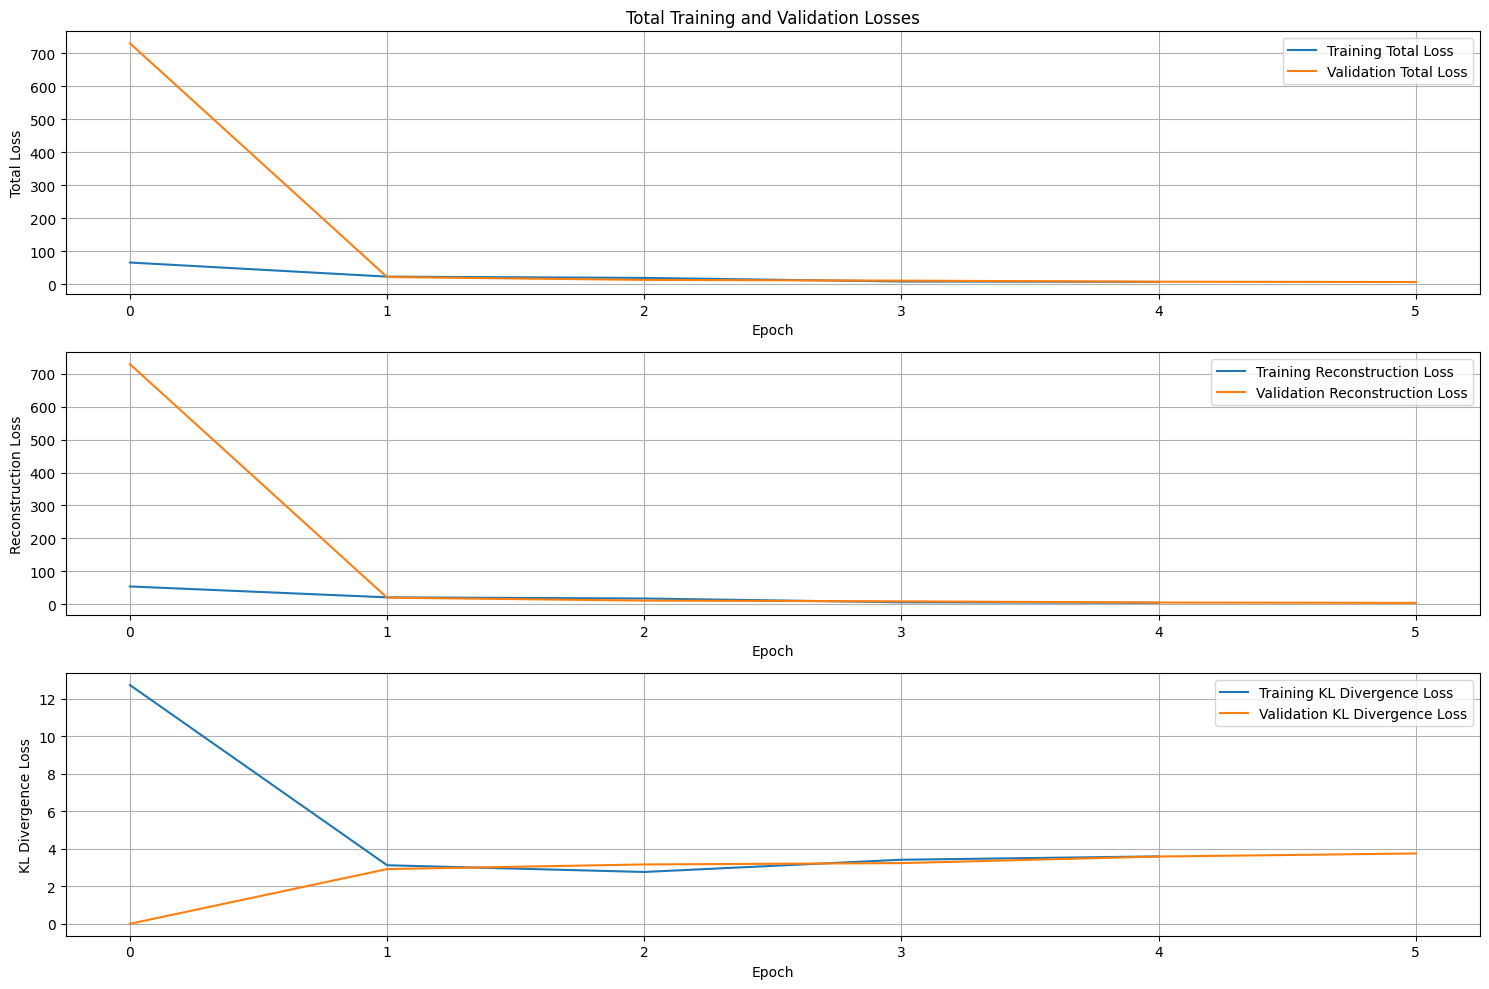

In [19]:
if want_to_train:
    add_experiment_metrics(experiments_folder, experiment_id=experiment_id, metrics=trainer.callback_metrics)
    torch.save(model.state_dict(), model_save_path)
    loss_history.plot_all_losses(save_path=model_losses_path)
else:
    model.load_state_dict(torch.load(model_save_path, weights_only=True))  

# Latent Space

## Dataset

In [20]:
latent_means, latent_log_vars = model.encode(scaled_data)

latent_means = latent_means.detach().numpy()
latent_log_vars = latent_log_vars.detach().numpy()
latent_representation = np.concatenate((latent_means, latent_log_vars), axis=1)
np.save(latent_representations_path, latent_representation)
latent_representation.shape

(45211, 4)

In [21]:
latent_log_vars = torch.from_numpy(latent_log_vars)
latent_stdevs = torch.exp(0.5 * latent_log_vars)
latent_stdevs = latent_stdevs.numpy()
latent_stdevs.shape

(45211, 2)

In [22]:
features.shape

(45211, 3)

Saved plot to ../experiments/experiment_6/images/exp6_latent_space


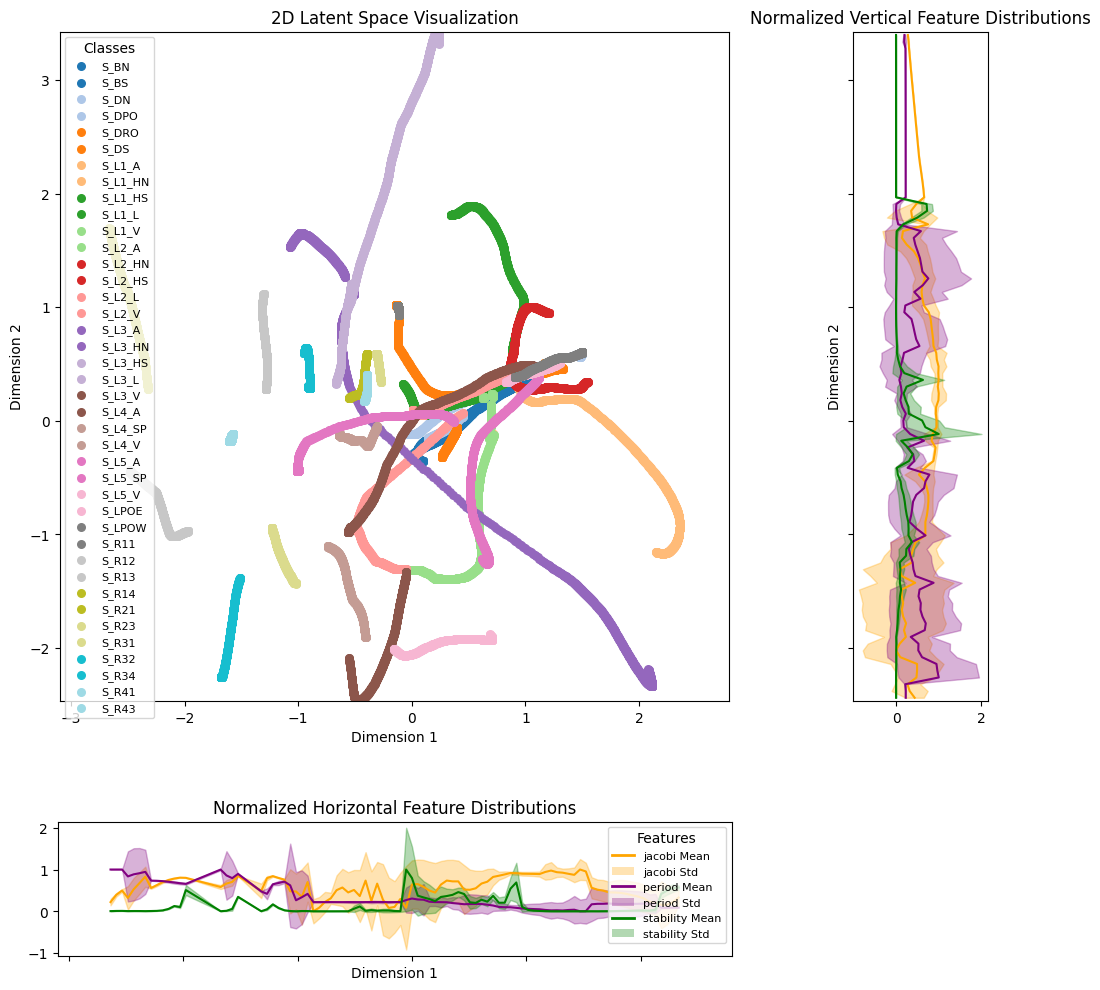

In [23]:
if latent_means.shape[1]==2:
    plot_2d_latent_space(latent_means,
                            np.array(family_labels),
                            save_path=latent_space_path,
                            features=features,
                            feature_names=feature_names,
                            plot_std=True)
else:
    rls=reduce_dimensions_latent_space(latent_means,
                                        np.array(family_labels),
                                        techniques=['PCA','UMAP','t-SNE'],
                                        save_path=latent_space_path,
                                        show_legend=False)

### Full Dataset

In [24]:
# Scale full data
full_scaled_data = scaler.transform(torch.tensor(full_data, dtype=torch.float32))

# Encode full data
full_latent_means, full_latent_log_vars= model.encode(full_scaled_data)

full_latent_means = full_latent_means.detach().numpy()

# Calculate stdevs
full_latent_stdevs = torch.exp(0.5 * full_latent_log_vars)
full_latent_stdevs = full_latent_stdevs.detach().numpy()
full_latent_stdevs.shape

(45211, 2)

In [25]:
full_family_labels=get_orbit_classes(full_orbits_id_classes)[0]
family_labels_discarded_train = [label if label in discarded_families else 'training' for label in full_family_labels]
family_labels_discarded_train = np.array(family_labels_discarded_train)
family_labels_discarded_train.shape

(45211,)

In [26]:
full_features=full_orbit_df[feature_names].to_numpy()
full_features.shape

(45211, 3)

In [29]:
if full_latent_means.shape[1]==2 and params['families_to_discard']!=0:
    plot_2d_latent_space(full_latent_means,
                            family_labels_discarded_train,
                            save_path=full_latent_space_path,
                            features=full_features,
                            feature_names=feature_names,
                            plot_std=True,
                            latent_stdevs=full_latent_stdevs)

In [30]:
discarded_orbit_indices = [i for i in range(len(family_labels_discarded_train)) if family_labels_discarded_train[i] != 'training']

if full_latent_means.shape[1]==2 and params['families_to_discard']!=0:
    plot_2d_latent_space(full_latent_means[discarded_orbit_indices],
                            family_labels_discarded_train[discarded_orbit_indices],
                            save_path=discarded_latent_space_path,
                            features=full_features[discarded_orbit_indices],
                            latent_stdevs=full_latent_stdevs[discarded_orbit_indices])


## Centroids

In [31]:
# Compute centroids
centroid_means = compute_centroids(latent_means, orbits_id_classes, method='mean')
centroid_log_vars = compute_centroids(latent_log_vars, orbits_id_classes, method='mean')
centroids_representation = np.concatenate((centroid_means, centroid_log_vars), axis=1)
np.save(family_centroids_path, centroids_representation)
centroid_log_vars = torch.from_numpy(centroid_log_vars)
centroid_stdevs = torch.exp(0.5 * centroid_log_vars)
centroid_stdevs = centroid_stdevs.numpy()
centroid_stdevs.shape

(40, 2)

In [32]:
# Compute centroid labels
unique_classes = remove_duplicates_preserve_order(orbits_id_classes)
family_names=get_orbit_classes(unique_classes)[0]
len(family_names)

40

In [33]:
# Compute full data centroid
full_data_centroid = np.mean(latent_means, axis=0)
full_data_centroid

array([0.12329144, 0.07327347], dtype=float32)

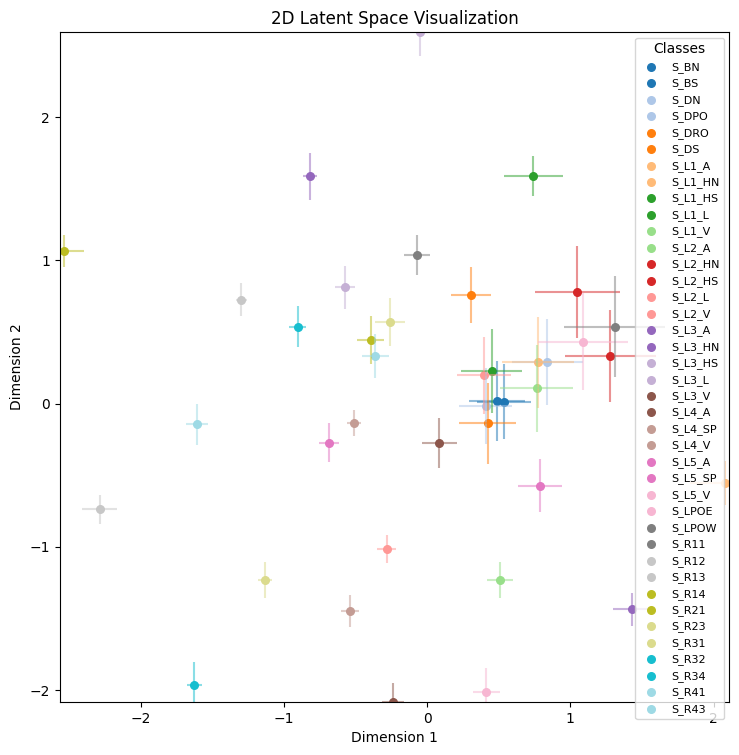

In [34]:
if latent_means.shape[1]==2:
    plot_2d_latent_space(centroid_means,
                            np.array(family_names),
                            save_path=family_centroids_plot_path,
                            latent_stdevs=centroid_stdevs
                            )
else:
    rls=reduce_dimensions_latent_space(centroid_means,
                                        np.array(family_names),
                                        techniques=['PCA','UMAP','t-SNE'],
                                        save_path=family_centroids_plot_path,
                                        show_legend=False)

### Full Centroids

In [35]:
# Compute centroids
full_centroid_means = compute_centroids(full_latent_means, full_orbits_id_classes, method='mean')
full_centroid_log_vars = compute_centroids(full_latent_log_vars.detach().numpy(), full_orbits_id_classes, method='mean')
full_centroid_stdevs = compute_centroids(full_latent_stdevs, full_orbits_id_classes, method='mean')
full_centroid_stdevs.shape

(40, 2)

In [36]:
# Calculate full centroid labels
full_unique_classes = remove_duplicates_preserve_order(full_orbits_id_classes)
full_family_names=get_orbit_classes(full_unique_classes)[0]
len(full_family_names)

40

In [37]:
families_discarded_train = [label if label in discarded_families else 'training' for label in full_family_names]
families_discarded_train = np.array(families_discarded_train)
len(families_discarded_train)

40

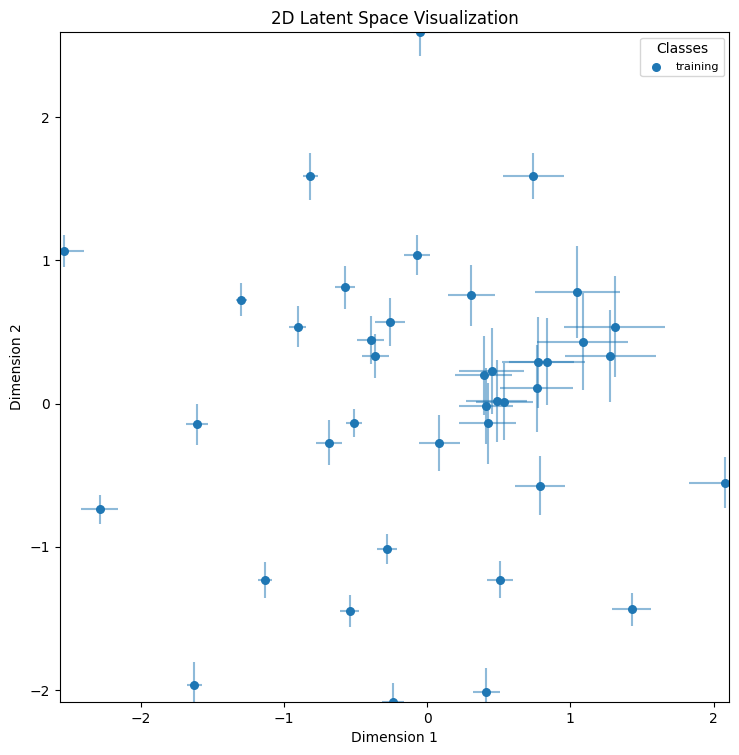

In [ ]:
if full_centroid_means.shape[1]==2 and params['families_to_discard']!=0:
    plot_2d_latent_space(full_centroid_means,
                            families_discarded_train,
                            save_path=full_family_centroids_plot_path,
                            latent_stdevs=full_centroid_stdevs
                            )

In [39]:
discarded_family_indices = [i for i in range(len(families_discarded_train)) if families_discarded_train[i] != 'training']
discarded_centroid_means = full_centroid_means[discarded_family_indices]
discarded_centroid_log_vars = full_centroid_log_vars[discarded_family_indices]
discarded_centroid_log_vars.shape

(0, 2)

## Clustering

In [40]:
if want_to_get_cluster_metrics:
    cluster_metrics = evaluate_clustering_multiple_labels(latent_means, [family_labels], label_names=['family'], clustering_method='gmm')
    add_experiment_metrics(experiments_folder, experiment_id=experiment_id, metrics=cluster_metrics)

Metrics added to experiment with ID 6 in ../experiments/experiments.json.


# Generation

Normal Sampling

In [51]:
if want_to_generate:
    random_generation = model.sample(params['samples_to_generate'])
    random_generation = scaler.inverse_transform(random_generation)
    print(random_generation.shape)

torch.Size([100, 7, 100])


Discarded Centroid Sampling

In [53]:
if want_to_generate:
    if params['families_to_discard']==0:
        discarded_centroids_generation = model.sample(params['samples_to_generate'])
    else:
        discarded_centroids_latent_samples = sample_random_distributions(discarded_centroid_means, discarded_centroid_log_vars, params['samples_to_generate'])
        discarded_centroids_generation = model.decode(discarded_centroids_latent_samples)
    discarded_centroids_generation = scaler.inverse_transform(discarded_centroids_generation)
    print(discarded_centroids_generation.shape)

torch.Size([100, 7, 100])


Grid Sampling

In [54]:
if want_to_generate:
    grid_samples = grid_sample(centroid_means, grid_size=(10,10))
    grid_generation = model.decode(torch.from_numpy(grid_samples))
    grid_generation = scaler.inverse_transform(grid_generation)
    print(grid_generation.shape)

torch.Size([100, 7, 100])


Save or Load

In [75]:
if want_to_generate:
    generation = torch.cat([random_generation, discarded_centroids_generation, grid_generation], dim=0)
    generation = generation.detach().cpu().numpy()
    np.save(generated_data_path, random_generation.detach().numpy())
else:
    generation = np.load(generated_data_path)

generation.shape

(300, 7, 100)

## Visualization

In [56]:
if torch.is_tensor(generation):
    generation=generation.detach().numpy()

if generation.shape[1] == 7:
    no_time_generation = generation[:,1:,:]
    generation.shape
else:
    no_time_generation = generation

no_time_generation.shape

(300, 6, 100)

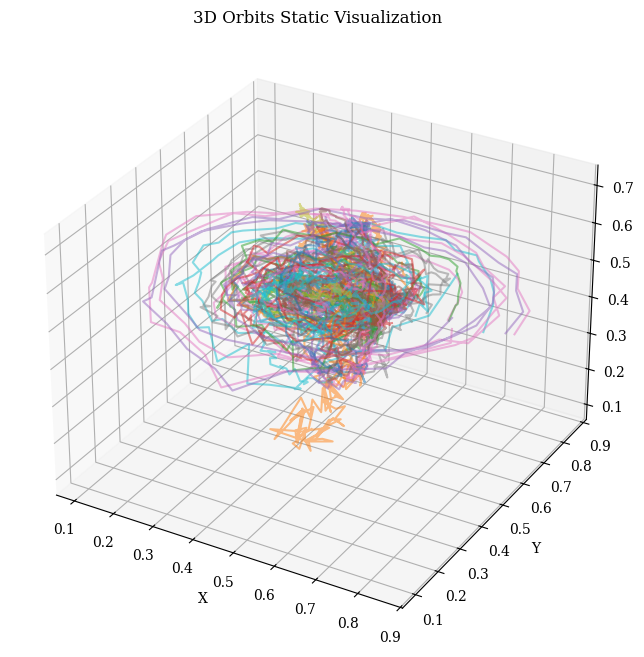

In [57]:
visualize_static_orbits(data= no_time_generation[0:100], show_legend=False, save_path=static_all_orbit_path)

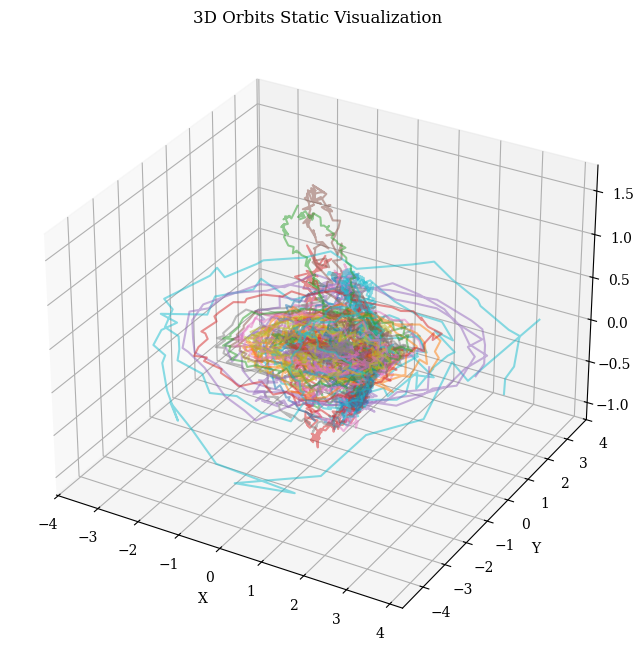

In [58]:
visualize_static_orbits(data= no_time_generation[100:200], show_legend=False)

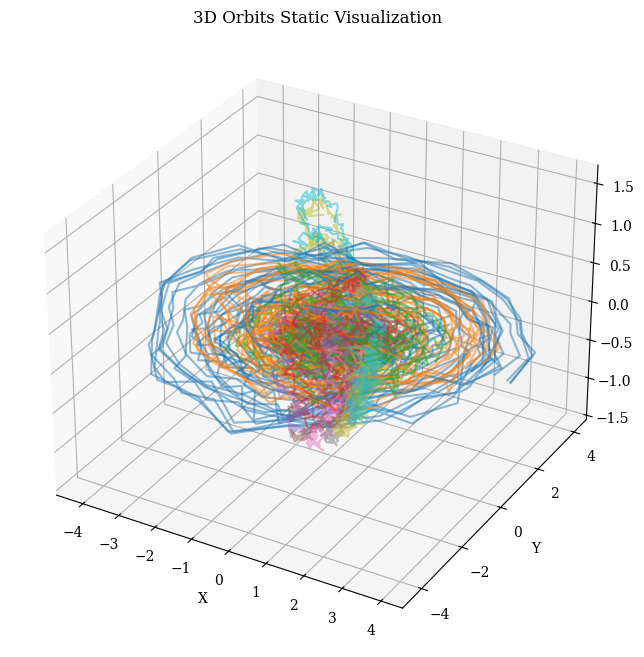

In [59]:
visualize_static_orbits(data= no_time_generation[200:300], show_legend=False)

In [60]:
export_dynamic_orbits_html(data=no_time_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_6/images/exp6_generated_orbits.html


## Coverage

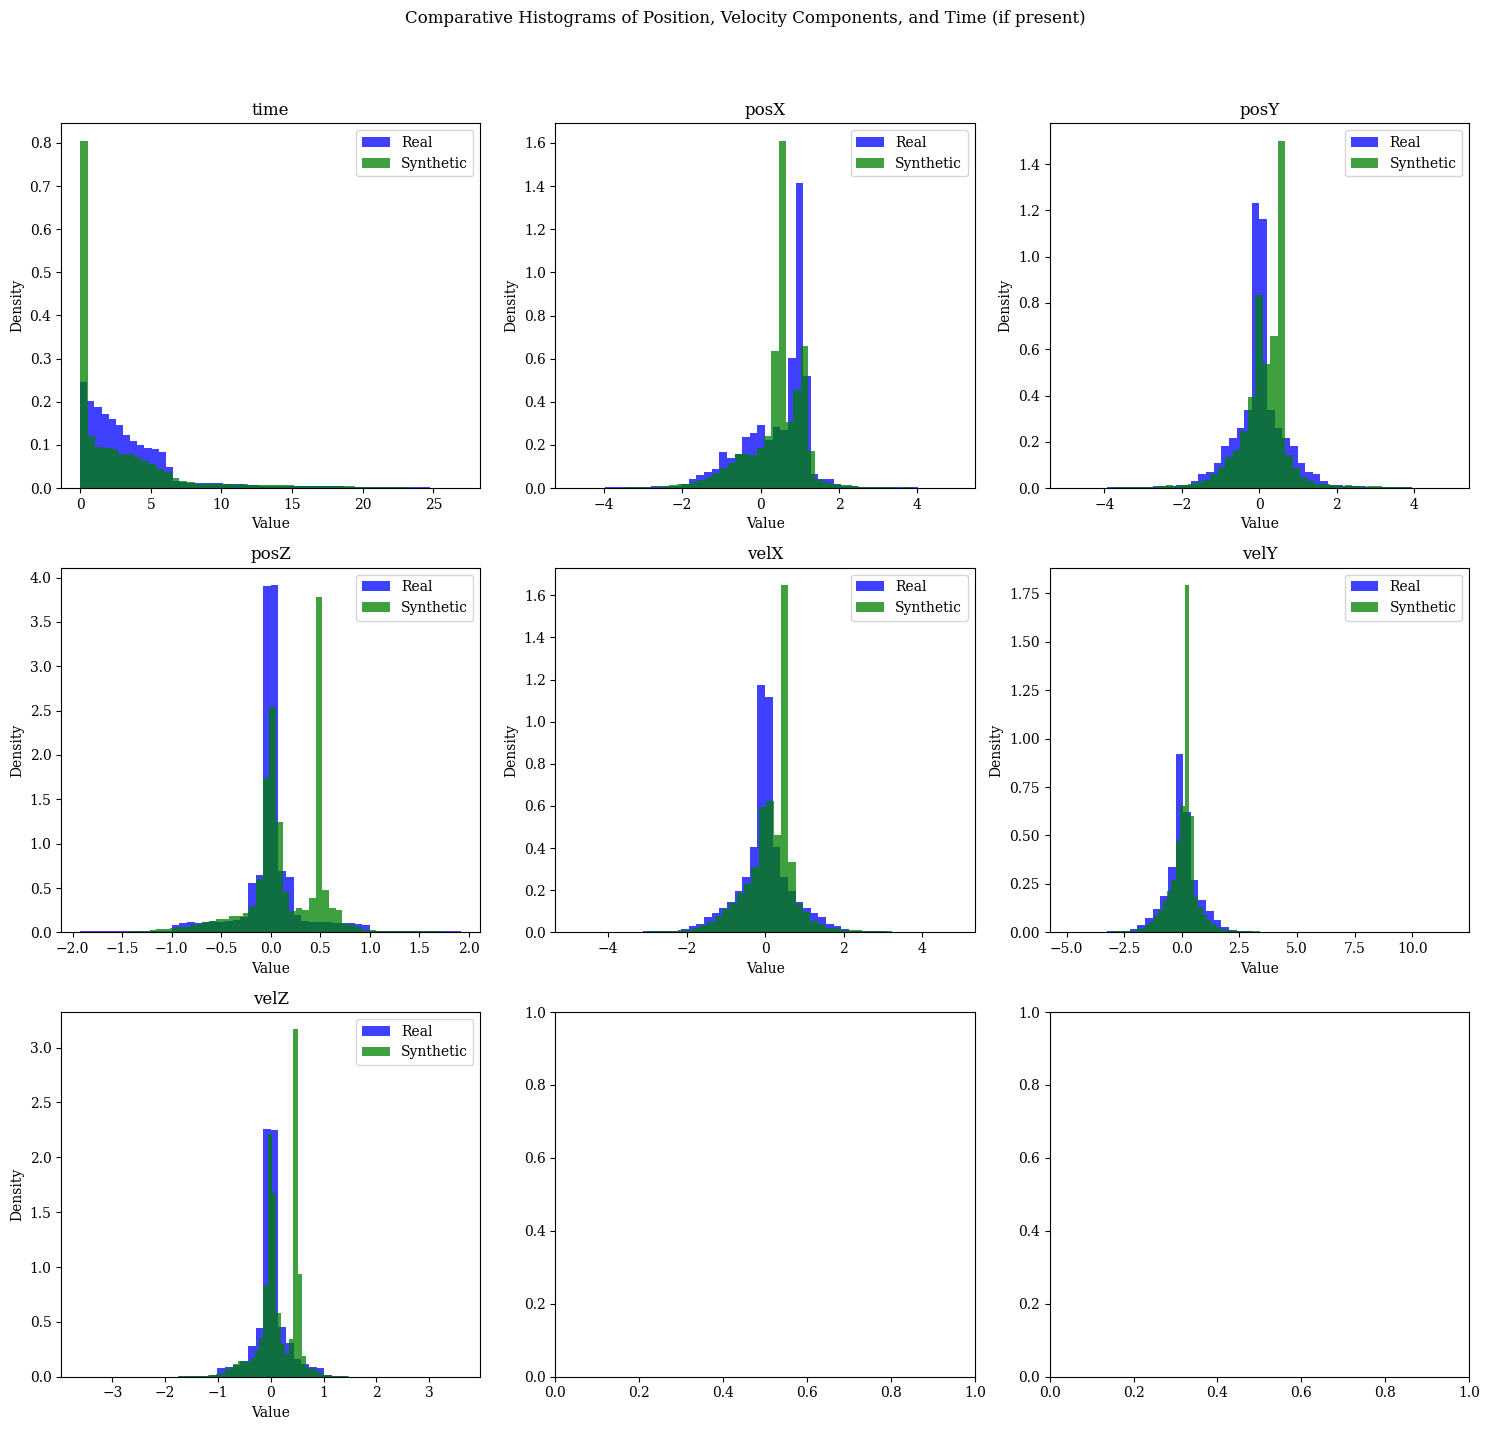

In [61]:
plot_histograms_comparison(data1=data, data2=generation, label1='Real', label2='Synthetic', normalize=True, save_path=histogram_comparison_path)

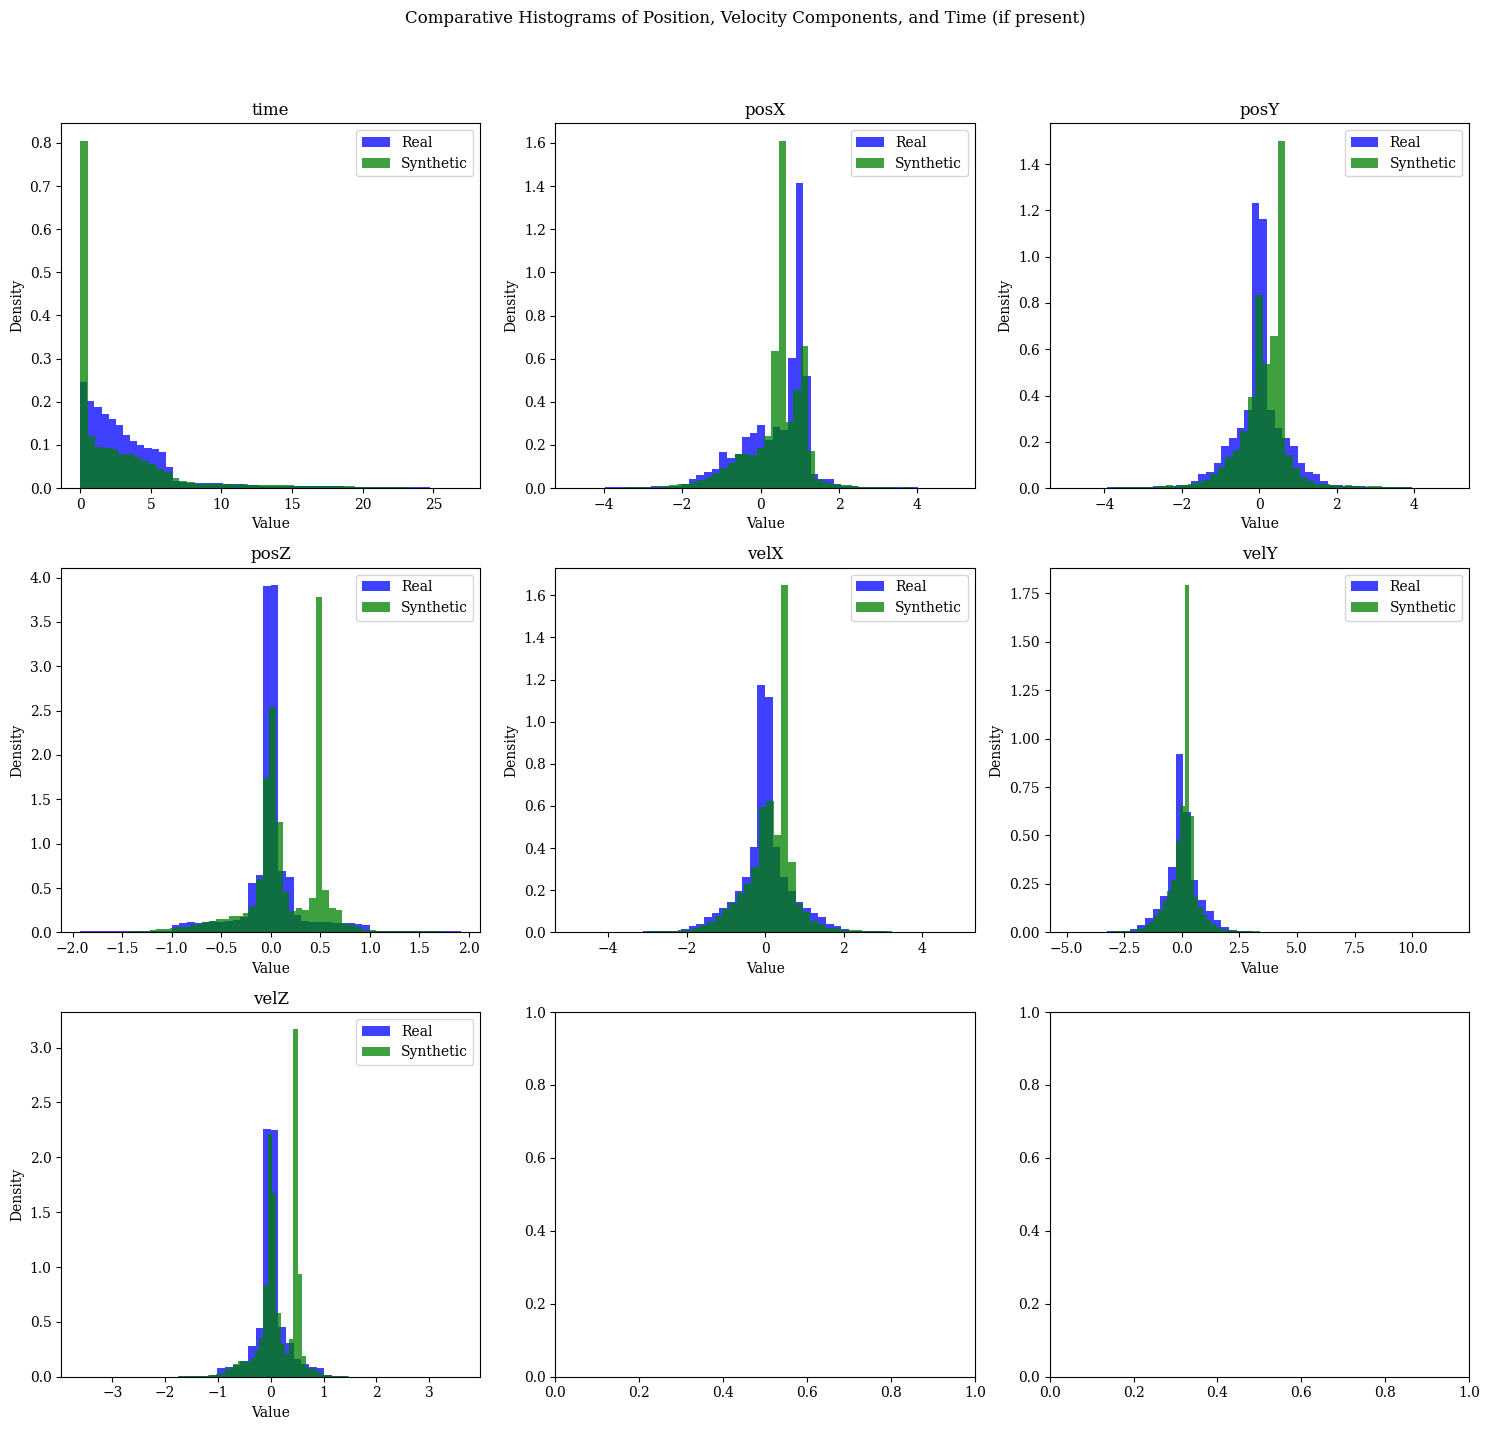

In [62]:
plot_histograms_comparison(data1=full_data, data2=generation, label1='Real', label2='Synthetic', normalize=True, save_path=full_histogram_comparison_path)

## Pheasibility

In [ ]:
if calculate_error_metrics:

    #Order metrics
    reordered_generation, order_metrics_array, order_metric_labels = reorder_orbits(generation)
    average_order_metrics = order_metrics_array.mean(axis=0)
    average_order_metrics_dict = dict(zip(order_metric_labels, average_order_metrics))

    # Pheasibility metrics
    per_orbit_errors = calculate_errors_per_orbit(reordered_generation,EM_MU)
    mean_errors = {key: np.mean(value) for key, value in per_orbit_errors.items()}
    
    generation_df = pd.DataFrame(per_orbit_errors)
    new_values_df = pd.DataFrame(order_metrics_array, columns=order_metric_labels)
    generation_df = pd.concat([generation_df, new_values_df], axis=1)

    add_experiment_metrics(experiments_folder, experiment_id=experiment_id, metrics={**mean_errors, **average_order_metrics_dict})

else:
    generation_df = pd.read_csv(generation_df_path)



Metrics added to experiment with ID 6 in ../experiments/experiments.json.


In [64]:
generation_df.head()

position_error  velocity_error  energy_error  disorder_metric  \
0        0.009345        0.009762      0.031461            316.0   
1        0.064146        0.083391      0.145274            730.0   
2        0.031043        0.027156      0.157517            106.0   
3        0.025478        0.038533      0.170020            202.0   
4        0.011666        0.013425      0.057380            280.0   

   correct_order  inversions  kendall_tau_distance  
0           59.0       214.0              0.089093  
1           61.0       489.0              0.220154  
2           74.0        64.0              0.027931  
3           60.0       129.0              0.055363  
4           63.0       187.0              0.077330

# Convergence

In [65]:
# Interpolate similar time values to suceed in convergence
interpolated_generation = interpolate_equal_times(reordered_generation)
interpolated_generation.shape

(300, 7, 100)

In [66]:
if want_to_perform_convergence:
    refined_orbits, refined_orbits_df= process_diferential_correction_orbits(np.transpose(interpolated_generation,(0,2,1)),
                                                                        EM_MU,
                                                                        max_iter=params['max_iter_convergence'])
    refined_orbits = np.transpose(refined_orbits,(0,2,1))
    np.save(refined_data_path, refined_orbits)
else:
    refined_orbits = np.load(refined_data_path)
    refined_orbits_df = pd.read_csv(refined_orbits_df_path)

refined_orbits.shape

INFO:orbit_generation.convergence:Processing orbit 1/300
INFO:orbit_generation.convergence:Orbit 0: Success=-1, Norm=7.50940934905391e-16, Iterations=25
INFO:orbit_generation.convergence:Processing orbit 2/300
INFO:orbit_generation.convergence:Orbit 1: Success=-1, Norm=1.09625739919858e-15, Iterations=25
INFO:orbit_generation.convergence:Processing orbit 3/300
INFO:orbit_generation.convergence:Orbit 2: Success=-1, Norm=1.1223003981239837e-15, Iterations=25
INFO:orbit_generation.convergence:Processing orbit 4/300
INFO:orbit_generation.convergence:Orbit 3: Success=-1, Norm=1.072457627502391e-15, Iterations=25
INFO:orbit_generation.convergence:Processing orbit 5/300
INFO:orbit_generation.convergence:Orbit 4: Success=-1, Norm=7.301351988545593e-16, Iterations=25
INFO:orbit_generation.convergence:Processing orbit 6/300
INFO:orbit_generation.convergence:Orbit 5: Success=-1, Norm=1.309522058799467e-15, Iterations=25
INFO:orbit_generation.convergence:Processing orbit 7/300
INFO:orbit_generatio

reducing tolerance 


INFO:orbit_generation.convergence:Orbit 121: Success=-1, Norm=11.586086248937338, Iterations=2
INFO:orbit_generation.convergence:Processing orbit 123/300
INFO:orbit_generation.convergence:Orbit 122: Success=1, Norm=5.750282788813521e-11, Iterations=11
INFO:orbit_generation.convergence:Processing orbit 124/300
INFO:orbit_generation.convergence:Orbit 123: Success=-1, Norm=3.1172946855346804e-14, Iterations=25
INFO:orbit_generation.convergence:Processing orbit 125/300
INFO:orbit_generation.convergence:Orbit 124: Success=-1, Norm=11.121321760980711, Iterations=4
INFO:orbit_generation.convergence:Processing orbit 126/300
INFO:orbit_generation.convergence:Orbit 125: Success=-1, Norm=12.789166379607275, Iterations=4
INFO:orbit_generation.convergence:Processing orbit 127/300
INFO:orbit_generation.convergence:Orbit 126: Success=1, Norm=5.3699256259806265e-12, Iterations=8
INFO:orbit_generation.convergence:Processing orbit 128/300
INFO:orbit_generation.convergence:Orbit 127: Success=-1, Norm=11.

(50, 7, 100)

Order Metrics

In [67]:
# Order orbits and average metrics
reordered_refined_orbits, refined_order_metrics_array, refined_order_metric_labels = reorder_orbits(refined_orbits)
refined_average_order_metrics = refined_order_metrics_array.mean(axis=0)
refined_order_metrics = dict(zip(refined_order_metric_labels, refined_average_order_metrics))

# Add individual metrics to the df
new_values_df = pd.DataFrame(refined_order_metrics_array, columns=refined_order_metric_labels)
refined_orbits_df = pd.concat([refined_orbits_df, new_values_df], axis=1)

refined_order_metrics

{'disorder_metric': np.float64(220.8),
 'correct_order': np.float64(67.28),
 'inversions': np.float64(142.58),
 'kendall_tau_distance': np.float64(0.05760808080808067)}

Pheasibility Metrics

In [68]:
refined_per_orbit_errors = calculate_errors_per_orbit(reordered_refined_orbits,EM_MU)
refined_orbits_df['propagated_position_error'] = refined_per_orbit_errors['position_error']
refined_orbits_df['propagated_velocity_error'] = refined_per_orbit_errors['velocity_error']
refined_orbits_df['propagated_energy_error'] = refined_per_orbit_errors['energy_error']
refined_mean_errors = {key: np.mean(value) for key, value in refined_per_orbit_errors.items()}
refined_mean_errors

{'position_error': np.float64(4.010995393595144e-12),
 'velocity_error': np.float64(7.995850478945354e-12),
 'energy_error': np.float64(2.757752939588601e-11)}

In [69]:
refined_orbits_df.head()

id  old_period  new_period  iterations_convergence         error  \
0  103    7.053864    6.301856                      10  4.524366e-12   
1  113    7.647600    6.251557                      12  9.054159e-13   
2  117    7.238757    6.294805                      11  3.379906e-13   
3  122    7.936484    5.320949                      11  5.750283e-11   
4  126    7.229114    6.296244                       8  5.369926e-12   

   initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
0        0.717489        0.480510        0.286253        0.224803   
1       -0.584694        0.045798        0.725079       -0.191777   
2        0.845825        0.460782        0.124102        0.214873   
3        1.060298        0.187143       -0.008171        0.269553   
4        0.808964        0.047822        0.494380        0.067651   

   initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
0       -0.866851        0.888312      0.668080      0.274334      0.685905   
1       -0.591782        0.067167     -0.525190      0.025368      0.851221   
2       -0.664345        0.792618      0.604425      0.553991      0.312313   
3       -0.860752        0.270068      1.099793      0.026052     -0.050501   
4       -1.702544        0.129040      0.713342     -0.312287      0.622307   

   final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
0     -0.426146     -0.697923      0.702877            130.0           70.0   
1      0.051053     -0.477269      0.045457            172.0           72.0   
2     -0.093074     -0.410146      0.889966            178.0           73.0   
3      0.101026     -0.256985      0.509573            312.0           63.0   
4     -0.621217     -1.657183     -0.114216            140.0           71.0   

   inversions  kendall_tau_distance  propagated_position_error  \
0        81.0              0.032727               1.218438e-12   
1       102.0              0.041212               1.004274e-12   
2       115.0              0.046465               9.538996e-13   
3       205.0              0.082828               1.593215e-12   
4        89.0              0.035960               9.912790e-13   

   propagated_velocity_error  propagated_energy_error  
0               2.597800e-12             6.276416e-13  
1               1.845187e-12             7.806550e-14  
2               1.784241e-12             5.993859e-14  
3               4.476123e-12             1.170583e-12  
4               3.829313e-12             3.672842e-13

In [70]:
refined_ids = refined_orbits_df['id'].astype(int).tolist()
generated_data_that_was_refined = generation[refined_ids]
generated_data_that_was_refined.shape

(50, 7, 100)

## Visualization

Refinement by Samplings

In [71]:
index_100 = refined_orbits_df[refined_orbits_df['id'] >= 100].index[0] if not refined_orbits_df[refined_orbits_df['id'] >= 100].empty else None
index_200 = refined_orbits_df[refined_orbits_df['id'] >= 200].index[0] if not refined_orbits_df[refined_orbits_df['id'] >= 200].empty else None

In [73]:
index_100

0

In [74]:
index_200

np.int64(29)

In [ ]:
if np.any(reordered_refined_orbits[:index_100,1:,:]):
    visualize_static_orbits(reordered_refined_orbits[:index_100,1:,:], show_legend=False)

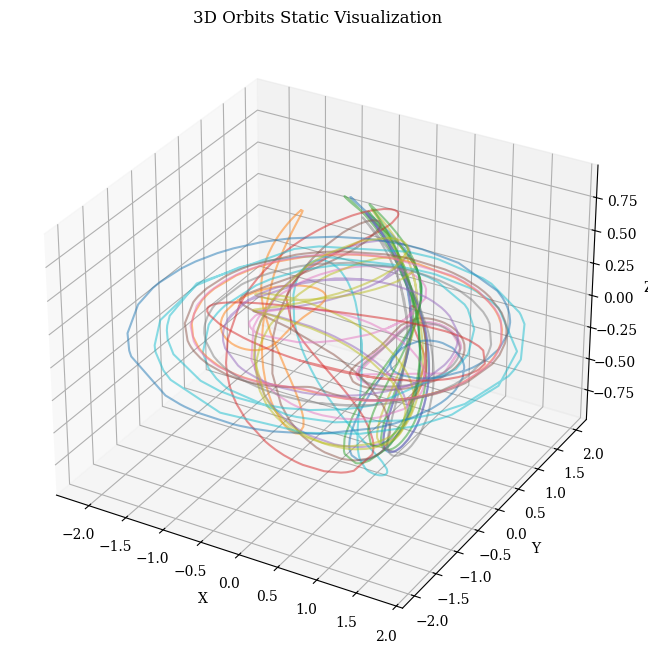

In [78]:
if np.any(reordered_refined_orbits[index_100:index_200,1:,:]):
    visualize_static_orbits(reordered_refined_orbits[index_100:index_200,1:,:], show_legend=False)

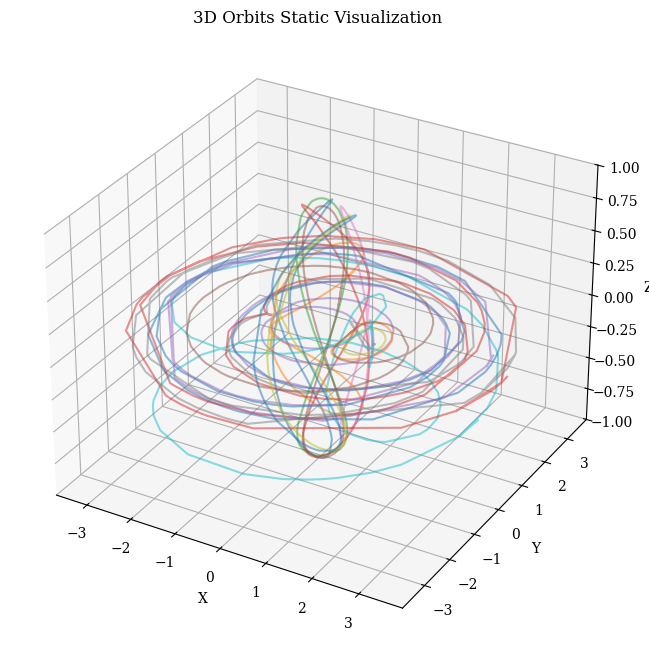

In [79]:
if np.any(reordered_refined_orbits[index_200:,1:,:]):
    visualize_static_orbits(reordered_refined_orbits[index_200:,1:,:], show_legend=False)

Generation that was able to get Refined

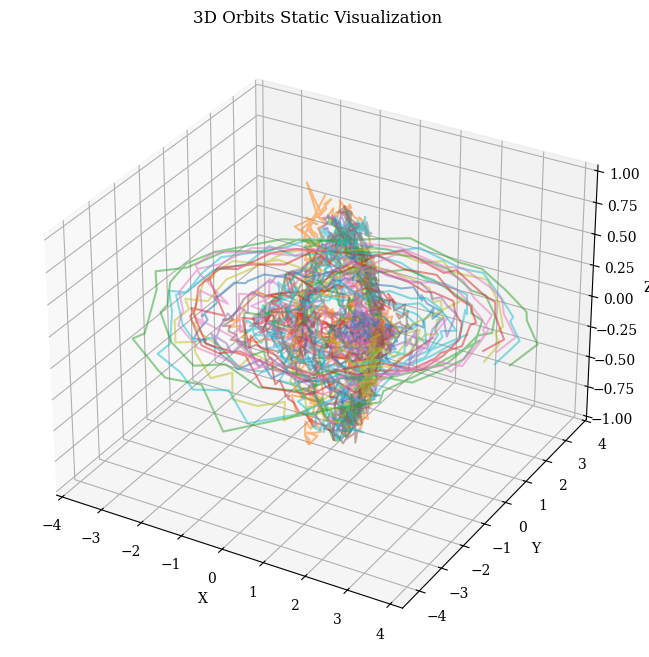

In [80]:
visualize_static_orbits(generated_data_that_was_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_converged_path)

Refinement

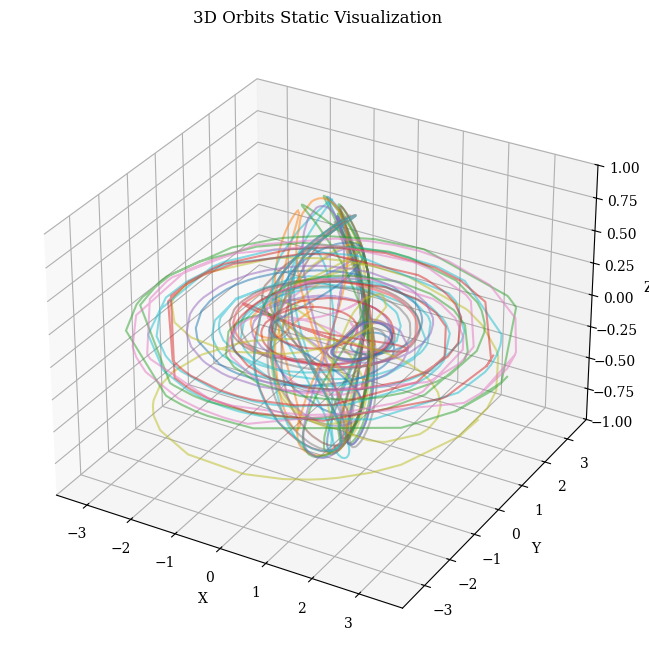

In [81]:
visualize_static_orbits(reordered_refined_orbits[:,1:,:], show_legend=False, save_path=refined_orbits_path)

Generation that didn't manage to get refined

In [82]:
non_refined_ids = sorted(set(range(3*params['samples_to_generate'])) - set(refined_ids))
generated_data_that_was_not_refined = generation[non_refined_ids]
generated_data_that_was_not_refined.shape

(250, 7, 100)

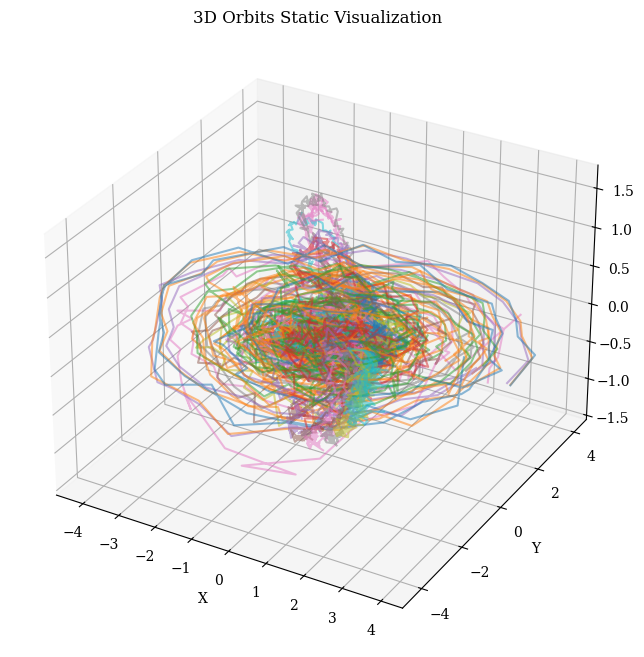

In [83]:
visualize_static_orbits(generated_data_that_was_not_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_did_not_converged_path)

## Latent Space

In [84]:
refined_scaled_data = scaler.transform(torch.from_numpy(refined_orbits).float())
refined_latent_means, refined_latent_log_vars = model.encode(refined_scaled_data)
refined_latent_means = refined_latent_means.detach().numpy()
refined_latent_log_vars = refined_latent_log_vars.detach().numpy()
refined_latent_representations = np.concatenate((refined_latent_means, refined_latent_log_vars), axis=1)
refined_latent_representations.shape

(50, 4)

Saved plot to ../experiments/experiment_6/images/exp6_combined_latent_space


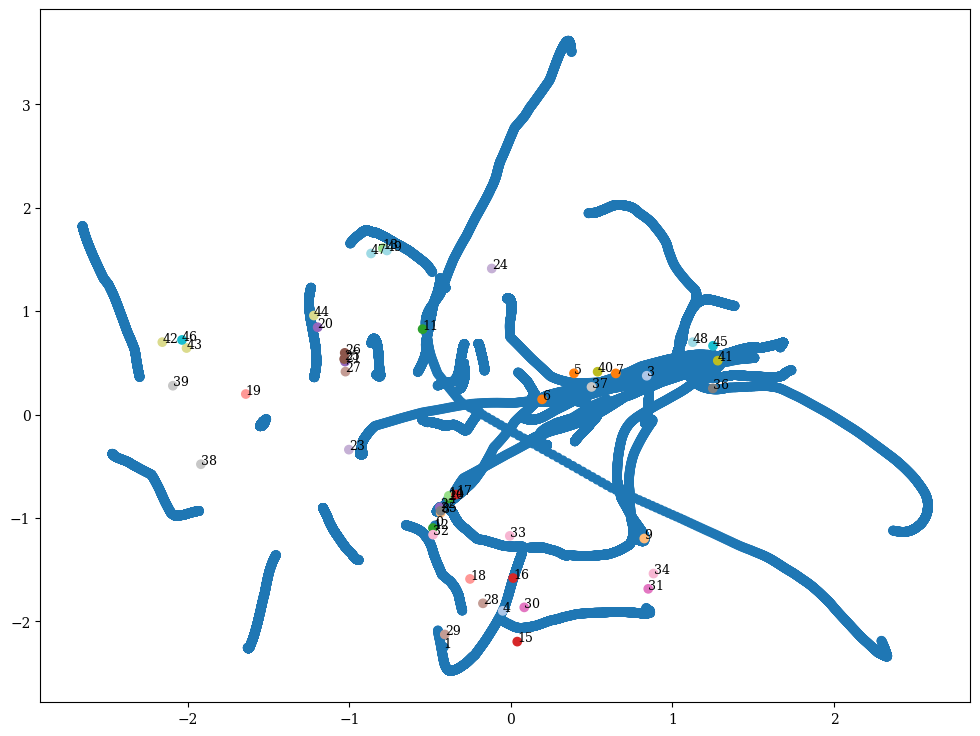

In [85]:
if refined_latent_means.shape[1]>2:
    rls=reduce_dimensions_latent_space(train_latent=latent_representation,
                                        val_latent=refined_latent_means)
    latent_representation=rls['PCA']['train']
    refined_latent_means=rls['PCA']['val']

plot_combined_2d_latent_space(
    real_latent=latent_means, 
    synthetic_latent=refined_latent_means,
    synthetic_labels=list(range(0, len(refined_scaled_data))),
    annotation_mode='numbers',
    save_path=combined_latent_space_path
)

In [86]:
scaled_generation = scaler.transform(torch.from_numpy(generation).float())
latent_generation_means, _ = model.encode(scaled_generation)
latent_generation_means = latent_generation_means.detach().numpy()
latent_generation_means_that_refined = latent_generation_means[refined_ids]
generation_to_refinement = np.stack((latent_generation_means_that_refined, refined_latent_means), axis=1)
generation_to_refinement.shape

(50, 2, 2)

Saved plot to ../experiments/experiment_6/images/exp6_combined_latent_space_arrows


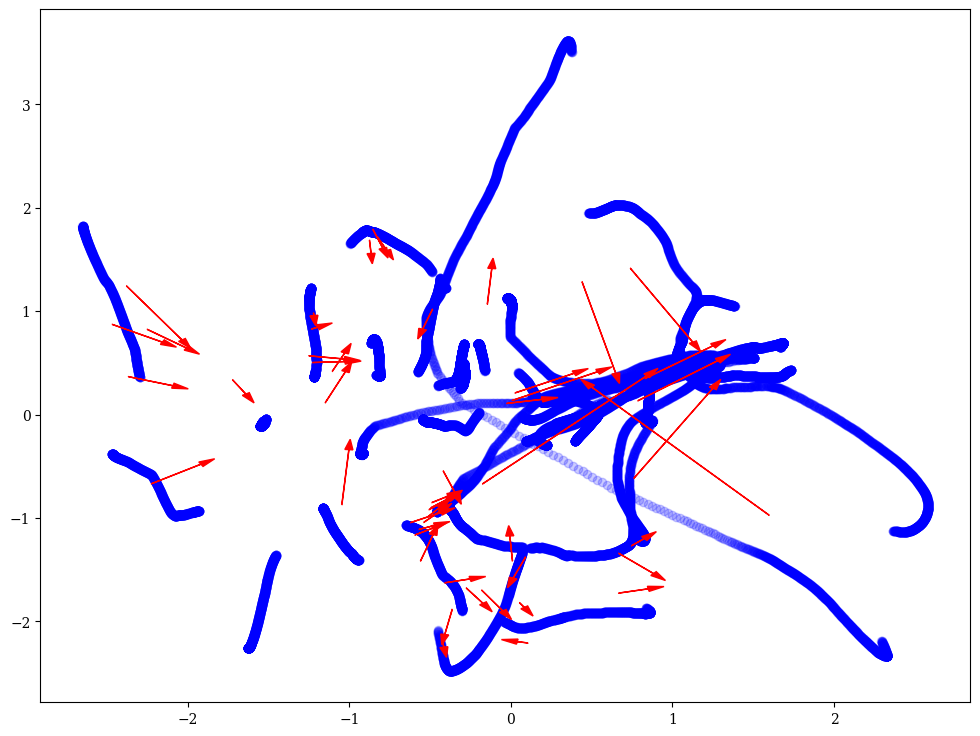

In [87]:
plot_combined_2d_latent_space(
    real_latent=latent_means, 
    synthetic_latent=generation_to_refinement,
    annotation_mode='numbers',
    save_path=combined_latent_space_arrows_path
)

In [88]:
generation_to_refinement_latent_distance = calculate_pairwise_distances(latent_generation_means_that_refined, refined_latent_means, distance_metric=params['distance_metric'])
refined_orbits_df['latent_distance_to_generation'] = generation_to_refinement_latent_distance

## Features

Calculate Jacobi Constant on the dataset

In [89]:
results = np.array([jacobi_constant(np.transpose(full_data[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(full_data.shape[0])])
full_orbit_df['calculated_jacobi'] = results

full_orbit_df.head()

id_class       x_0           y_0       x_0          vx_0      vy_0  \
0       1.0  0.941000  1.900442e-23  0.509474  2.968938e-13 -0.124968   
1       1.0  0.941538 -8.592698e-24  0.508602  2.902340e-13 -0.125672   
2       1.0  0.942076  6.956604e-24  0.507729  2.685527e-13 -0.126375   
3       1.0  0.942613  1.763946e-24  0.506856  3.153637e-13 -0.127078   
4       1.0  0.943150  9.441804e-24  0.505982  2.663322e-13 -0.127781   

           vz_0    jacobi     period   stability  propagated_periods  \
0 -3.122717e-12  2.745412  11.555291  211.184678                 3.0   
1 -3.252212e-12  2.746226  11.551622  210.329145                 3.0   
2 -2.862050e-12  2.747039  11.547936  209.473685                 3.0   
3 -3.791054e-12  2.747850  11.544233  208.618315                 3.0   
4 -2.982720e-12  2.748660  11.540511  207.763051                 3.0   

   calculated_jacobi  
0           2.757415  
1           2.758229  
2           2.759042  
3           2.759853  
4           2.760663

Calculate Jacobi Constant and Period on the Refined Orbits

In [90]:
new_jacobis = np.array([jacobi_constant(np.transpose(refined_orbits[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(refined_orbits.shape[0])])
refined_orbits_df['calculated_jacobi'] = new_jacobis
refined_orbits_df.rename(columns={'new_period': 'period'}, inplace=True)
refined_orbits_df['period_distance_with_generation'] = abs(refined_orbits_df['period'] - refined_orbits_df['old_period'])
refined_orbits_df.head()

id  old_period    period  iterations_convergence         error  \
0  103    7.053864  6.301856                      10  4.524366e-12   
1  113    7.647600  6.251557                      12  9.054159e-13   
2  117    7.238757  6.294805                      11  3.379906e-13   
3  122    7.936484  5.320949                      11  5.750283e-11   
4  126    7.229114  6.296244                       8  5.369926e-12   

   initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
0        0.717489        0.480510        0.286253        0.224803   
1       -0.584694        0.045798        0.725079       -0.191777   
2        0.845825        0.460782        0.124102        0.214873   
3        1.060298        0.187143       -0.008171        0.269553   
4        0.808964        0.047822        0.494380        0.067651   

   initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
0       -0.866851        0.888312      0.668080      0.274334      0.685905   
1       -0.591782        0.067167     -0.525190      0.025368      0.851221   
2       -0.664345        0.792618      0.604425      0.553991      0.312313   
3       -0.860752        0.270068      1.099793      0.026052     -0.050501   
4       -1.702544        0.129040      0.713342     -0.312287      0.622307   

   final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
0     -0.426146     -0.697923      0.702877            130.0           70.0   
1      0.051053     -0.477269      0.045457            172.0           72.0   
2     -0.093074     -0.410146      0.889966            178.0           73.0   
3      0.101026     -0.256985      0.509573            312.0           63.0   
4     -0.621217     -1.657183     -0.114216            140.0           71.0   

   inversions  kendall_tau_distance  propagated_position_error  \
0        81.0              0.032727               1.218438e-12   
1       102.0              0.041212               1.004274e-12   
2       115.0              0.046465               9.538996e-13   
3       205.0              0.082828               1.593215e-12   
4        89.0              0.035960               9.912790e-13   

   propagated_velocity_error  propagated_energy_error  \
0               2.597800e-12             6.276416e-13   
1               1.845187e-12             7.806550e-14   
2               1.784241e-12             5.993859e-14   
3               4.476123e-12             1.170583e-12   
4               3.829313e-12             3.672842e-13   

   latent_distance_to_generation  calculated_jacobi  \
0                       0.106304           1.368464   
1                       0.049397           2.057237   
2                       0.153148           1.978497   
3                       1.458924           2.854368   
4                       0.239094          -0.529564   

   period_distance_with_generation  
0                         0.752008  
1                         1.396043  
2                         0.943952  
3                         2.615535  
4                         0.932870

Compare Features between Dataset and Refinement

Saved plot to ../experiments/experiment_6/images/exp6_features


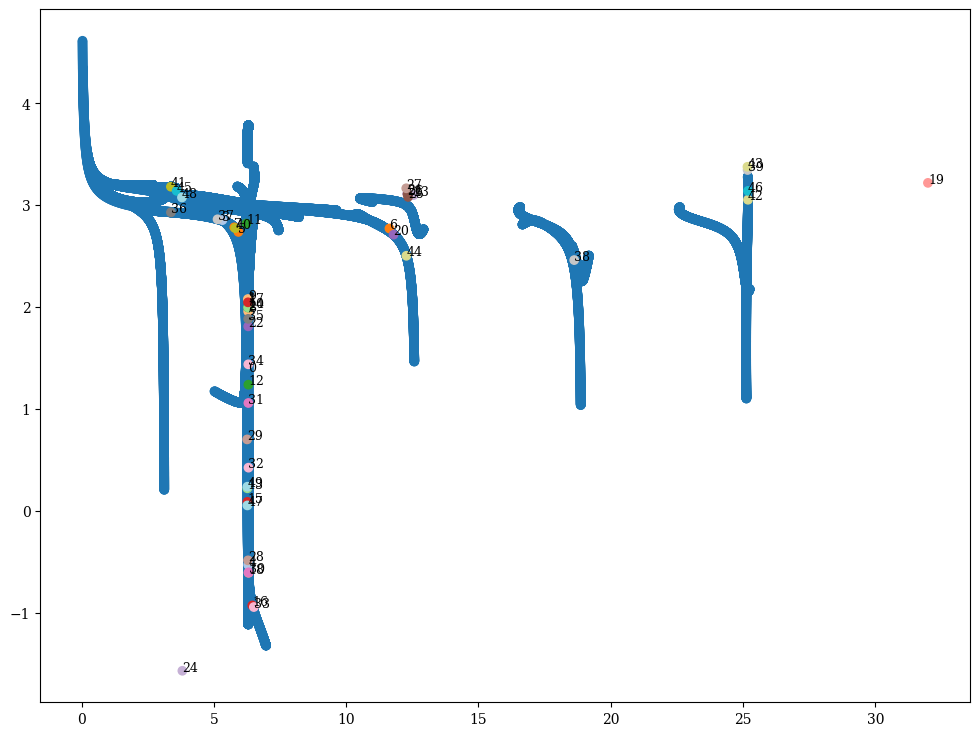

In [91]:
features_used = ['period', 'calculated_jacobi']

dataset_features = full_orbit_df[features_used].values
refined_orbits_features = refined_orbits_df[features_used].values 

closest_feature_indices, feature_distances = find_nearest_points_batch(refined_orbits_features, dataset_features,
                                                                       n=1, distance_metric=params['distance_metric'])

refined_orbits_df['feature_closest_orbit'] = closest_feature_indices
refined_orbits_df['feature_distance_from_closest_orbit'] = feature_distances

plot_combined_2d_latent_space(dataset_features, refined_orbits_features,
                              synthetic_labels=list(range(0, len(refined_scaled_data))),
                              annotation_mode='numbers', save_path=features_plot_path)

Feature Centroids

In [92]:
array_features = full_orbit_df[features_used].to_numpy()
feature_centroid = full_orbit_df[features_used].mean().to_numpy()
feature_centroids = compute_centroids(array_features, full_orbits_id_classes, method='mean')
feature_centroids.shape

(40, 2)

In [93]:
stdev_feature_centroids  = full_orbit_df.groupby('id_class')[features_used].std().values
stdev_feature_centroids.shape

(40, 2)

In [94]:
feature_centroid = full_orbit_df[features_used].mean().values
feature_centroid.shape

(2,)

In [95]:
full_unique_classes = list(set(full_orbits_id_classes))
full_family_names=get_orbit_classes(full_unique_classes)[0]
len(full_family_names)

40

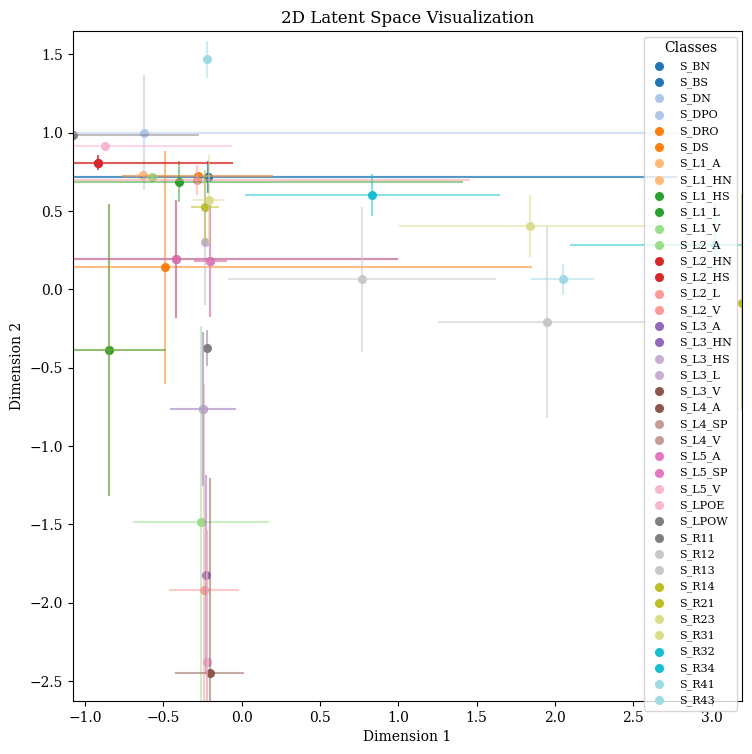

In [96]:
if len(features_used)==2:
    plot_2d_latent_space(feature_centroids,np.array(full_family_names), latent_stdevs=stdev_feature_centroids, save_path=family_feature_centroids_plot_path)

## Calculate distances

In [97]:
if data.shape[1] == 7:
    no_time_data = full_data[:,1:,:]
    no_time_refined_orbits = refined_orbits[:,1:,:]
    no_time_generated_data_that_was_refined = generated_data_that_was_refined[:,1:,:]
else:
    no_time_data = full_data
    no_time_refined_orbits = refined_orbits
    no_time_generated_data_that_was_refined = generated_data_that_was_refined

print(no_time_data.shape)
print(no_time_refined_orbits.shape)
print(no_time_generated_data_that_was_refined.shape)
print(no_time_generation.shape)


(45211, 6, 100)
(50, 6, 100)
(50, 6, 100)
(300, 6, 100)


### Orbit Distances

1. Nearest Orbit

In [98]:
nearest_indices_generation, nearest_distances_generation = find_nearest_orbits_batch(no_time_generation,
                                                                                     no_time_data,
                                                                                     n=1,
                                                                                     distance_metric=params['distance_metric'])
generation_df['nearest_orbit'] = nearest_indices_generation
generation_df['nearest_orbit_distance'] = nearest_distances_generation

In [99]:
nearest_indices_refined_generation, nearest_distances_refined_generation = find_nearest_orbits_batch(no_time_refined_orbits,
                                                                                                     no_time_data,
                                                                                                     n=1,
                                                                                                     distance_metric=params['distance_metric'])
refined_orbits_df['nearest_orbit'] = nearest_indices_refined_generation
refined_orbits_df['nearest_orbit_distance'] = nearest_distances_refined_generation

2. Generation vs Refinement

In [100]:
pairwise_distances = calculate_pairwise_orbit_distances(no_time_generated_data_that_was_refined,
                                                        no_time_refined_orbits, distance_metric=params['distance_metric'])
refined_orbits_df['distance_from_generation'] = pairwise_distances

### Point Distances

3. Distance from the centre

In [101]:
# Latent space distance
centroid_distances = calculate_distances_batch(full_data_centroid, refined_latent_means, distance_metric=params['distance_metric'])
refined_orbits_df['centroid_distance'] = centroid_distances

In [102]:
# Feature distance
feature_centroid_distances = calculate_distances_batch(feature_centroid, refined_orbits_features, distance_metric=params['distance_metric'])
refined_orbits_df['feature_centroid_distance'] = feature_centroid_distances

4. Distance from centroids

In [103]:
# Latent Space Centroids
closest_family_centroid, closest_family_centroid_distance = find_nearest_points_batch(refined_latent_means, centroid_means, n=1, distance_metric=params['distance_metric'])
refined_orbits_df['closest_family_centroid'] = closest_family_centroid
refined_orbits_df['closest_family_centroid_distance'] = closest_family_centroid_distance

In [104]:
# Feature Space Centroids
closest_family_feature_centroid, closest_family_feature_centroid_distance = find_nearest_points_batch(refined_orbits_features, feature_centroids, n=1, distance_metric=params['distance_metric'])
refined_orbits_df['closest_family_feature_centroid'] = closest_family_feature_centroid
refined_orbits_df['closest_family_feature_centroid_distance'] = closest_family_feature_centroid_distance

5. Initial Conditions

In [105]:
# Extract initial and final conditions
initial_conditions = refined_orbits_df[['initial_pos_x0', 'initial_pos_y0', 'initial_pos_z0',
                        'initial_vel_x0', 'initial_vel_y0', 'initial_vel_z0']].values
final_conditions = refined_orbits_df[['final_pos_x0', 'final_pos_y0', 'final_pos_z0',
                      'final_vel_x0', 'final_vel_y0', 'final_vel_z0']].values

ics_distances = calculate_pairwise_distances(initial_conditions, final_conditions, distance_metric=params['distance_metric'])
refined_orbits_df['initial_conditions_distance'] = ics_distances

## Export Features

In [106]:
generation_df.to_csv(generation_df_path, index=False)
generation_df.shape

(300, 9)

In [107]:
generation_df.head()

position_error  velocity_error  energy_error  disorder_metric  \
0        0.009345        0.009762      0.031461            316.0   
1        0.064146        0.083391      0.145274            730.0   
2        0.031043        0.027156      0.157517            106.0   
3        0.025478        0.038533      0.170020            202.0   
4        0.011666        0.013425      0.057380            280.0   

   correct_order  inversions  kendall_tau_distance  nearest_orbit  \
0           59.0       214.0              0.089093          26791   
1           61.0       489.0              0.220154          26793   
2           74.0        64.0              0.027931          26782   
3           60.0       129.0              0.055363          26793   
4           63.0       187.0              0.077330          26792   

   nearest_orbit_distance  
0                9.982549  
1               10.770676  
2                9.976524  
3                9.887084  
4                9.882703

In [108]:
refined_orbits_df.to_csv(refined_orbits_df_path, index=False)
refined_orbits_df.shape

(50, 39)

In [109]:
refined_orbits_df.head()

id  old_period    period  iterations_convergence         error  \
0  103    7.053864  6.301856                      10  4.524366e-12   
1  113    7.647600  6.251557                      12  9.054159e-13   
2  117    7.238757  6.294805                      11  3.379906e-13   
3  122    7.936484  5.320949                      11  5.750283e-11   
4  126    7.229114  6.296244                       8  5.369926e-12   

   initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
0        0.717489        0.480510        0.286253        0.224803   
1       -0.584694        0.045798        0.725079       -0.191777   
2        0.845825        0.460782        0.124102        0.214873   
3        1.060298        0.187143       -0.008171        0.269553   
4        0.808964        0.047822        0.494380        0.067651   

   initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
0       -0.866851        0.888312      0.668080      0.274334      0.685905   
1       -0.591782        0.067167     -0.525190      0.025368      0.851221   
2       -0.664345        0.792618      0.604425      0.553991      0.312313   
3       -0.860752        0.270068      1.099793      0.026052     -0.050501   
4       -1.702544        0.129040      0.713342     -0.312287      0.622307   

   final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
0     -0.426146     -0.697923      0.702877            130.0           70.0   
1      0.051053     -0.477269      0.045457            172.0           72.0   
2     -0.093074     -0.410146      0.889966            178.0           73.0   
3      0.101026     -0.256985      0.509573            312.0           63.0   
4     -0.621217     -1.657183     -0.114216            140.0           71.0   

   inversions  kendall_tau_distance  propagated_position_error  \
0        81.0              0.032727               1.218438e-12   
1       102.0              0.041212               1.004274e-12   
2       115.0              0.046465               9.538996e-13   
3       205.0              0.082828               1.593215e-12   
4        89.0              0.035960               9.912790e-13   

   propagated_velocity_error  propagated_energy_error  \
0               2.597800e-12             6.276416e-13   
1               1.845187e-12             7.806550e-14   
2               1.784241e-12             5.993859e-14   
3               4.476123e-12             1.170583e-12   
4               3.829313e-12             3.672842e-13   

   latent_distance_to_generation  calculated_jacobi  \
0                       0.106304           1.368464   
1                       0.049397           2.057237   
2                       0.153148           1.978497   
3                       1.458924           2.854368   
4                       0.239094          -0.529564   

   period_distance_with_generation  feature_closest_orbit  \
0                         0.752008                  27646   
1                         1.396043                  24488   
2                         0.943952                  27910   
3                         2.615535                  19106   
4                         0.932870                  23921   

   feature_distance_from_closest_orbit  nearest_orbit  nearest_orbit_distance  \
0                             0.001449          27600                3.924730   
1                             0.000082          24498                2.550258   
2                             0.000076          24727                3.514952   
3                             0.000582          19118                1.852277   
4                             0.001369          23933                5.483486   

   distance_from_generation  centroid_distance  feature_centroid_distance  \
0                  4.574152           1.289012                   1.406263   
1                  4.475685           2.383345                   1.060070   
2                  5.589177           1.030431                

In [110]:
not_to_show_columns = ['initial_pos_x0','initial_pos_y0','initial_pos_z0',	'initial_vel_x0',	'initial_vel_y0',	'initial_vel_z0	final_pos_x0',	'final_pos_y0',	'final_pos_z0',	'final_vel_x0',	'final_vel_y0',	'final_vel_z0', 'inversions',	'kendall_tau_distance' , 'closest_feature_indices',	'nearest_orbit', 'closest_family_centroid', 'closest_family_feature_centroid']

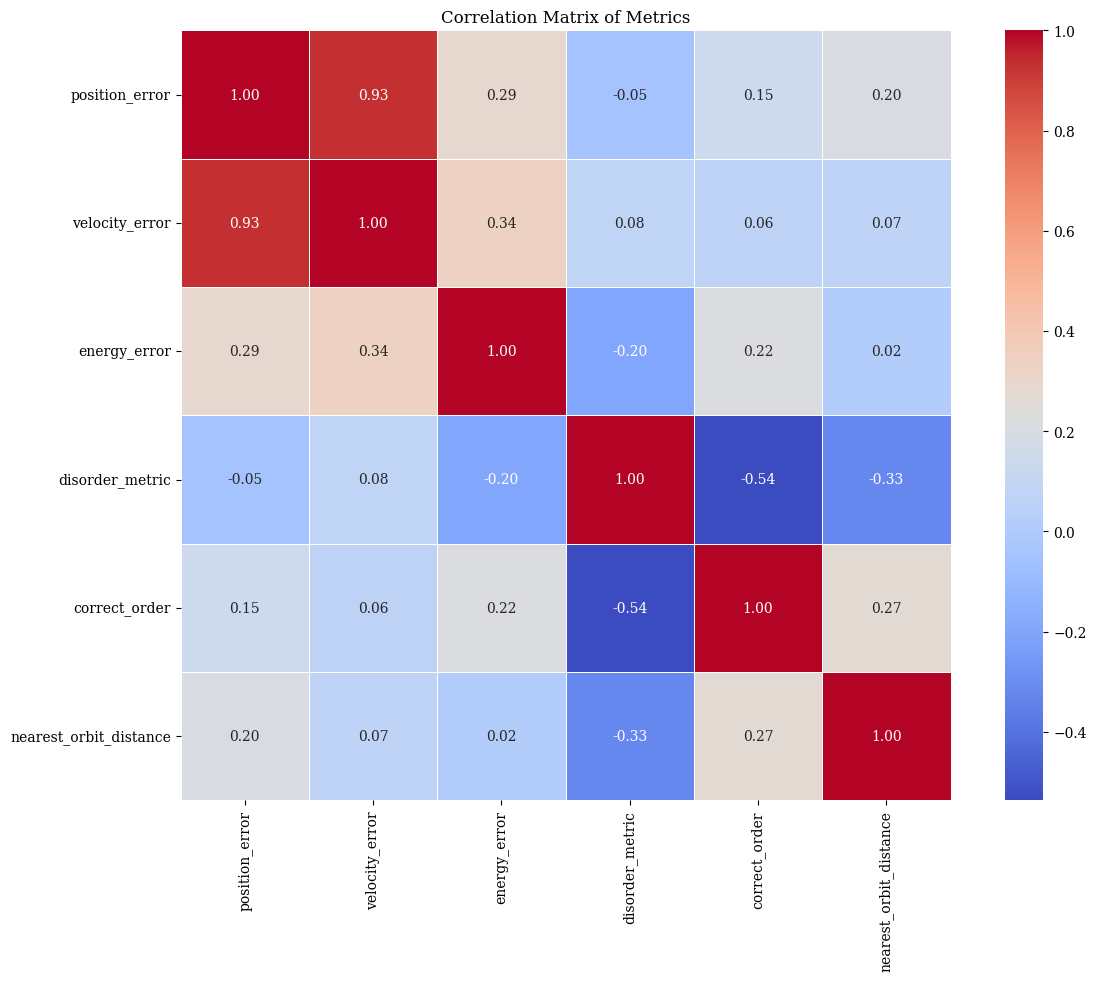

In [111]:
plot_corr_matrix(generation_df.drop(columns=not_to_show_columns, errors='ignore'))

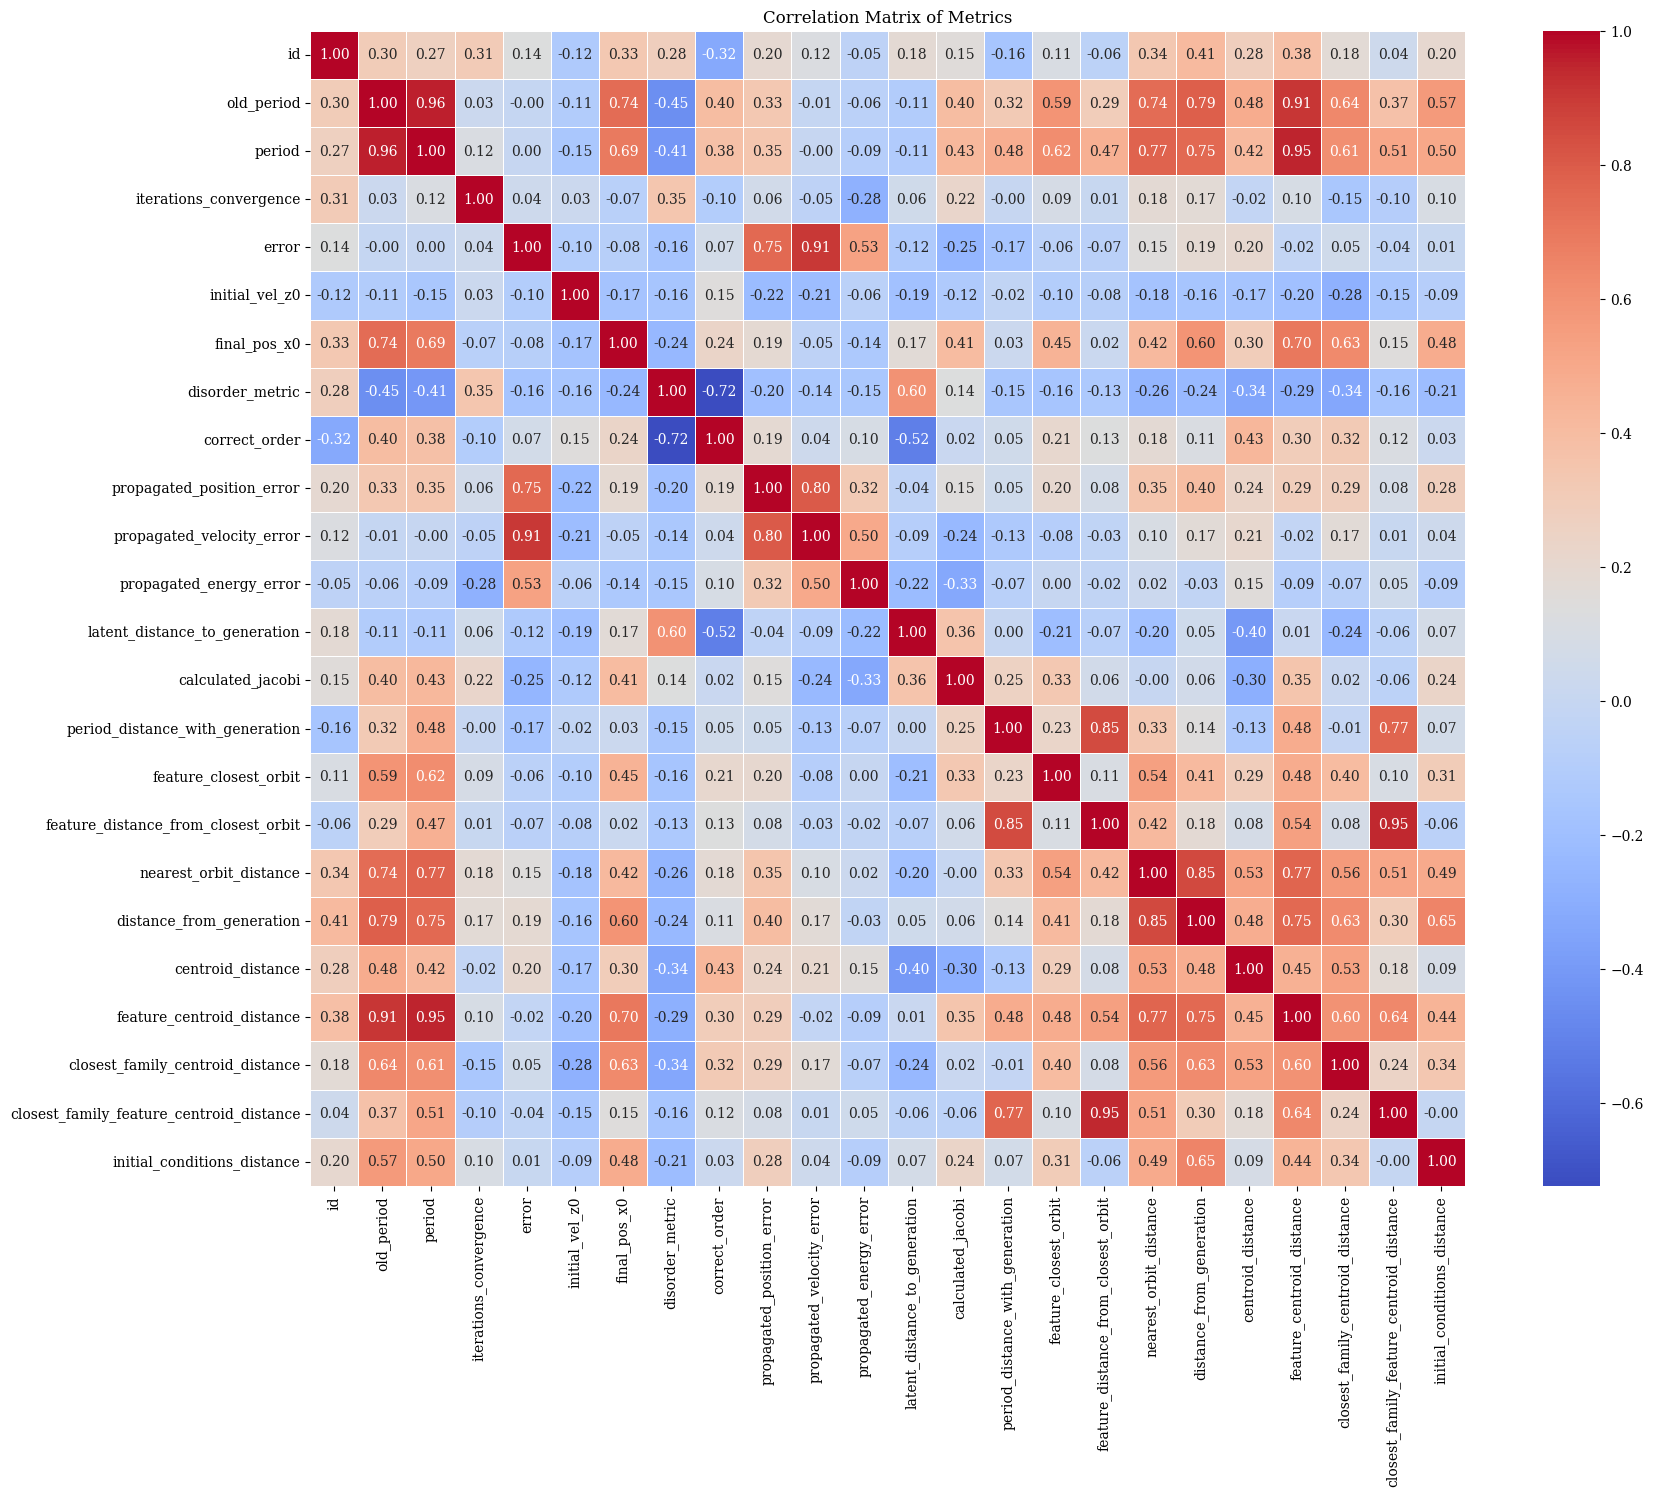

In [112]:
plot_corr_matrix(refined_orbits_df.drop(columns=not_to_show_columns, errors='ignore'), figsize=(20,15))

# Check Discovery

Calculate Full Centroid Distances

In [113]:
# Recalculate distance from latent space centroids
closest_family_centroid, closest_family_centroid_distance = find_nearest_points_batch(refined_latent_means, full_centroid_means, n=1, distance_metric=params['distance_metric'])
refined_orbits_df['closest_family_full_centroid'] = closest_family_centroid
refined_orbits_df['closest_family_full_centroid_distance'] = closest_family_centroid_distance

In [114]:
family_mapping = full_orbit_df['id_class'].to_dict()

def get_class_name(orbit_id):
    return family_mapping.get(orbit_id, None)

refined_orbits_df['family_of_feature_closest_orbit'] = refined_orbits_df['feature_closest_orbit'].apply(get_class_name)
refined_orbits_df['family_of_closest_orbit'] = refined_orbits_df['nearest_orbit'].apply(get_class_name)
refined_orbits_df.to_csv(refined_orbits_df_path, index=False)
refined_orbits_df.shape

(50, 43)

In [115]:
family_columns = ['family_of_feature_closest_orbit', 'family_of_closest_orbit', 'closest_family_feature_centroid','closest_family_full_centroid']
filter_condition = refined_orbits_df[family_columns].isin(discarded_family_ids).any(axis=1)
close_discovery_df = refined_orbits_df[filter_condition]
close_discovery_df.shape

(0, 43)

In [116]:
close_discovery_df[family_columns].head()

Empty DataFrame
Columns: [family_of_feature_closest_orbit, family_of_closest_orbit, closest_family_feature_centroid, closest_family_full_centroid]
Index: []

In [117]:
filter_condition = refined_orbits_df[['family_of_feature_closest_orbit', 'family_of_closest_orbit']].isin(discarded_family_ids).any(axis=1)
discovery_df = refined_orbits_df[filter_condition]
discovery_df.shape

(0, 43)

In [118]:
family_orbit_columns = ['id','feature_closest_orbit', 'nearest_orbit', 'family_of_feature_closest_orbit', 'family_of_closest_orbit', 'closest_family_feature_centroid','closest_family_full_centroid']
discovery_df[family_orbit_columns]

Empty DataFrame
Columns: [id, feature_closest_orbit, nearest_orbit, family_of_feature_closest_orbit, family_of_closest_orbit, closest_family_feature_centroid, closest_family_full_centroid]
Index: []

In [119]:
discarded_family_ids

[]

In [120]:
refinement_indexes = discovery_df.index.to_list()
feature_closest_orbit_indexes = discovery_df['feature_closest_orbit'].to_list()
nearest_orbit_indexes = discovery_df['nearest_orbit'].to_list()

discovery_refinement = reordered_refined_orbits[refinement_indexes]
feature_closest_orbits = full_data[feature_closest_orbit_indexes]
nearest_orbits = full_data[nearest_orbit_indexes]

In [121]:
refinement_and_closers = np.stack(
    (discovery_refinement, feature_closest_orbits, nearest_orbits),
    axis=1
)
refinement_and_closers.shape

(0, 3, 7, 100)

## Visualize

In [122]:
for i in range(len(refinement_and_closers)):
    visualize_static_orbits(refinement_and_closers[i,:,1:,:])

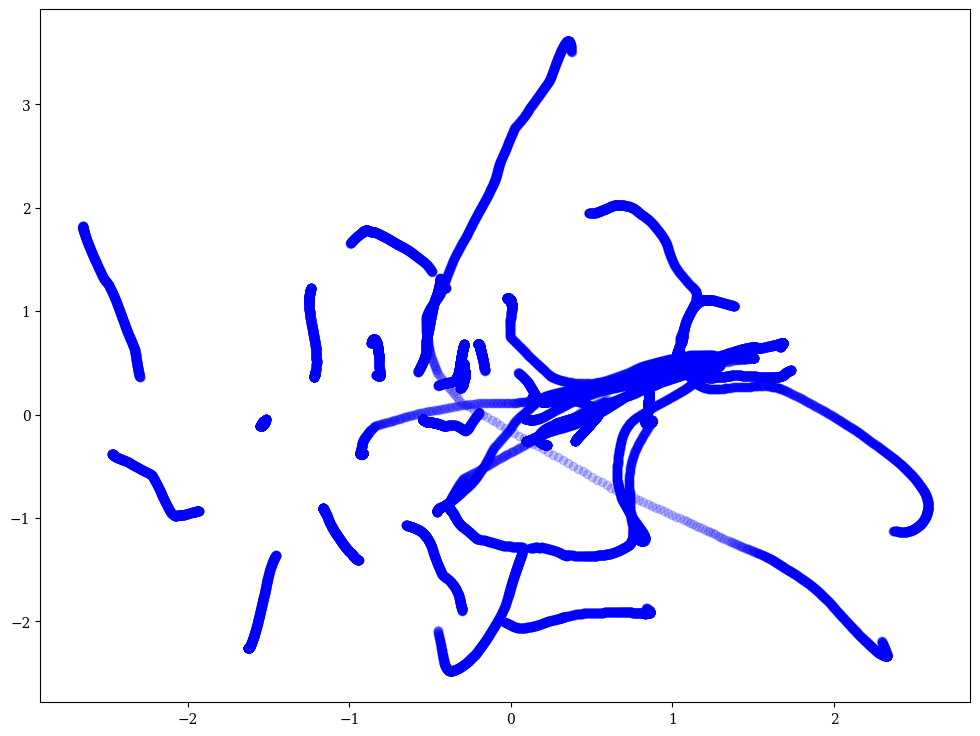

In [123]:
plot_combined_2d_latent_space(
    real_latent=latent_means, 
    synthetic_latent=generation_to_refinement[refinement_indexes],
    annotation_mode='numbers'
)

In [124]:
discovery_generation_indexes = discovery_df['id'].values
discovery_generation = generation[discovery_generation_indexes]
discovery_generation.shape

(0, 7, 100)

In [125]:
discovery_generation_and_refinement = np.stack(
    (discovery_generation, discovery_refinement),
    axis=1
)
discovery_generation_and_refinement.shape

(0, 2, 7, 100)

In [126]:
for i in range(len(discovery_generation_and_refinement)):
    visualize_static_orbits(discovery_generation_and_refinement[i,:,1:,:])